Definition of city network functions and creation of the city network.

In [5]:
from typing import NamedTuple
Vector3 = NamedTuple(
    'Vector3',
    [('x', int), ('y', int), ('z', int)]
)

from random import SystemRandom
rand = SystemRandom()

from math import dist


def Generate_Random_Network(
    city_count: int
) -> list[Vector3]:
    '''
    The function generates a random network of cities of size city_count
    '''
    random_network: list[Vector3] = []

    city_clusters = [
        Vector3(
            rand.randint(0, 1000),
            rand.randint(0, 1000),
            rand.randint(0, 1000),
        )
        for _ in range(
            3
            if city_count >= 3
            else city_count
        )
    ]

    for _ in range(city_count):
        city_cluster = rand.choice(
            city_clusters,
        )

        random_network.append(
            Vector3(
                city_cluster.x + rand.randint(-100, 100),
                city_cluster.y + rand.randint(-100, 100),
                city_cluster.z + rand.randint(-100, 100),
            )
        )

    return random_network


def Cycle_Distance(
    cycle_to_measure: list[Vector3]
) -> float:
    '''
    The function calculates the total distance traveled within a cycle
    '''
    from itertools import pairwise

    return sum([
        dist(
            start_city,
            stop_city
        )
        for start_city, stop_city in pairwise(
            cycle_to_measure[0:] + cycle_to_measure[:0]
        )
    ]) + dist(
        cycle_to_measure[-1],
        cycle_to_measure[0]
    )


def Generate_Nearest_Neighbor_Cycle(
    source_cities: list[Vector3],
    initial_city_index: int
) -> list[Vector3]:
    '''
    The function generates a nearest neighbor cycle starting from initial_city
    '''
    source_cities = [
        Vector3(*city)
        for city in source_cities
    ]
    nearest_neighbor_cycle = [source_cities[initial_city_index]]

    if len(source_cities) > 1:
        cities_left = [
            city
            for city in source_cities
            if city != source_cities[initial_city_index]
        ]

        nearest_neighbor_cycle += Generate_Nearest_Neighbor_Cycle(
            cities_left,
            cities_left.index(
                min(
                    cities_left,
                    key=lambda city: dist(
                        city,
                        nearest_neighbor_cycle[-1]
                    )
                )
            )
        )

    return nearest_neighbor_cycle


def Swap_3_Opt(
    city_cycle: list[Vector3]
) -> list[Vector3]:
    city_count = len(city_cycle)

    split_indices = sorted(
        rand.sample(
            range(
                1,
                city_count
            ),
            3
        )
    )

    sub_cycles = [
        city_cycle[start_index:stop_index]
        for start_index, stop_index in zip(
            [0] + split_indices,
            split_indices + [city_count]
        )
    ]

    shortest_distance = Cycle_Distance(city_cycle)
    shortest_cycle = city_cycle

    for sub_cycle_to_flip in range(1, 8):
        new_cycle = sub_cycles[0]

        for sub_cycle_index, sub_cycle in enumerate(sub_cycles[1:]):
            if sub_cycle_to_flip & 1 << sub_cycle_index:
                sub_cycle = sub_cycle[::-1]
            new_cycle.extend(sub_cycle)

        new_distance = Cycle_Distance(new_cycle)

        if new_distance < shortest_distance:
            shortest_cycle = [Vector3(*city) for city in new_cycle]
            shortest_distance = new_distance

    return shortest_cycle


Creation of the traveling salesman problem

In [6]:
INITIAL_CITY = 0
CITY_COUNT = 10

cities = Generate_Random_Network(CITY_COUNT)
initial_cycle = Generate_Nearest_Neighbor_Cycle(
    cities,
    INITIAL_CITY
)


Invocation of the simulated annealing algorithm

In [7]:
from math import exp
from Simulated_Annealing import Simulated_Annealing

INITIAL_TEMPERATURE = 100
optimal_cycle = Simulated_Annealing(
    initial_cycle,
    Swap_3_Opt,
    Cycle_Distance,
    (
        INITIAL_TEMPERATURE * exp(-temperature)
        for temperature in range(INITIAL_TEMPERATURE)
    )
)


Plotting the TSP search space and simulated annealing's optimized cycle.

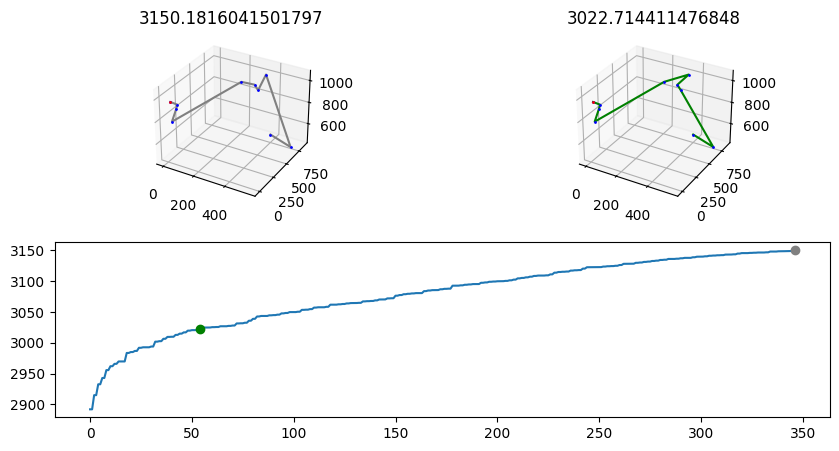

In [8]:
from matplotlib import pyplot as pl
from itertools import permutations

annealing_plot = pl.figure(figsize=(10, 5))
annealing_plot_grid = annealing_plot.add_gridspec(2, 2)

all_city_cycles = sorted(
    [
        [initial_cycle[0]] + list(permutation)
        for permutation in permutations(
            initial_cycle[1:]
        )
    ],
    key=Cycle_Distance
)

all_city_cycles = all_city_cycles[:all_city_cycles.index(
    max(
        [
            optimal_cycle,
            initial_cycle
        ],
        key=Cycle_Distance
    )
) + 1]

all_city_cycles_distances = [
    Cycle_Distance(cycle)
    for cycle in all_city_cycles
]

bottom_plot = annealing_plot.add_subplot(annealing_plot_grid[1, :])
bottom_plot.plot(
    *zip(*enumerate(all_city_cycles_distances)),
    markersize=1
)

for index, cycle in enumerate(
    [
        initial_cycle,
        optimal_cycle
    ]
):
    index_in_all_city_cycles = all_city_cycles.index(cycle)
    bottom_plot.plot(
        index_in_all_city_cycles,
        all_city_cycles_distances[index_in_all_city_cycles],
        'o',
        color='green' if cycle is optimal_cycle else 'gray'
    )

    ax = annealing_plot.add_subplot(
        annealing_plot_grid[index & 2, index & 1],
        projection='3d'
    )
    ax.set_title(f'{Cycle_Distance(cycle)}')

    ax.plot(
        *zip(*cycle),
        color='green' if cycle is optimal_cycle else 'gray',
        markersize=1
    )
    ax.plot(*zip(*cities), 'bo', markersize=1)
    ax.plot(*cities[INITIAL_CITY], 'ro', markersize=1)

pl.show()
pl.close()